In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from sklearn import gaussian_process
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.base import BaseEstimator, TransformerMixin

file_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
field_types = {"Date":"str", # Date in format dd/mm/yyyy 
               "Time":"str", # time in format hh:mm:ss 
               "Global_active_power":"float", # household global minute-averaged active power (in kilowatt) 
               "Global_reactive_power":"float", # household global minute-averaged reactive power (in kilowatt) 
               "Voltage":"float", # minute-averaged voltage (in volt) 
               "Global_intensity":"float", # household global minute-averaged current intensity (in ampere) 
               "Sub_metering_1":"float", # energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
               "Sub_metering_2":"float", # energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. 
               "Sub_metering_3":"float" # energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.
              }

/Users/jattenberg/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
power_df = pd.read_csv(file_url, sep=";", header=0, parse_dates=[['Date', 'Time']], dtype=field_types, na_values=["?"], index_col="Date_Time")

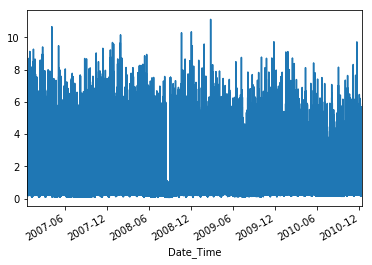

In [3]:
power_df["Global_active_power"].plot()

In [4]:
def ae(y, yh):
    return np.abs(y-yh)
def se(y, yh):
    return (y-yh)**2.0
def pae(y, yh):
    return np.abs(y-yh)/y
def pse(y, yh):
    return ((y-yh)/y)**2.0

evaluators = {
    "absolute error"  : ae,
    "squared error"   : se,
    "% absolute error": pae,
    "% squared error" : pse
}

def predict(model, training_points, predict_point):
    return model.fit(training_points).transform(predict_point)

def compile_results(results):
    result_df = pd.DataFrame.from_dict(results)
    return result_df.mean(axis=0)

def evaluate(df, model, train_pct=0.66, predict_column="Global_active_power", iterations=1, print_period=200):
    """
        really simple time series model evaluation
        this is slow as heck, moves one point at a time
    """
    train_size = int(len(df)*train_pct)
    train = df[predict_column][:train_size].dropna(axis=0)
    test = df[predict_column][train_size:].dropna(axis=0)

    points = train
    evals = []
    i = 0
    for t in test:
        p = predict(model, points, t)        
        evals = evals + [dict([(name, fn(t, p)) for name, fn in evaluators.items()])]
        points = points + [t]
        
        if i%print_period == 0:
            print compile_results(evals)
        
        i = i + 1
        
        if i >= iterations:
            break
            
    return evals

In [5]:
class ARIMAModel(BaseEstimator, TransformerMixin):
    def __init__(self, p=5, d=1, q=1, verbosity=0):
        self.p = p
        self.d = d
        self.q = q
        self.verbosity = verbosity
        self.arima = None
        
    def fit(self, X, y=None):
        self.arima = ARIMA(X, order=(self.p, self.d, self.q))
        return self
    
    def transform(self, X):
        return self.arima.fit(disp=self.verbosity).forecast()[0][0]
    
arima_metrics = evaluate(power_df, ARIMAModel(p=5,d=1,q=0,verbosity=1))

% absolute error    0.003132
% squared error     0.000010
absolute error      0.004002
squared error       0.000016
dtype: float64


In [6]:
class SKLRollingModel(BaseEstimator, TransformerMixin):
    def __init__(self, skmodel, lookback=10):
        self.model = skmodel
        self.lookback = lookback + 1
    def fit(self, X, y=None):
        
        idx = np.arange(self.lookback)[::-1] + np.arange(len(X))[:,None] - self.lookback + 1
        out = X.get_values()[idx]
        out[idx<0] = np.nan
        out = out[~np.isnan(out).any(axis=1)]
        
        x = out[:, 1:]
        y = out[:, 0]
        
        self.model.fit(x[:-1], y[:-1])
        self.score = self.model.predict(x[-1].reshape(1, -1))
        return self
        
    def transform(self, X):
        return self.score
    

lin_scores = evaluate(power_df, SKLRollingModel(linear_model.LinearRegression()))

/Users/jattenberg/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


% absolute error    2.019677e-04
% squared error     4.079097e-08
absolute error      2.581148e-04
squared error       6.662324e-08
dtype: float64
